In [3]:
using Pkg
Pkg.activate(".")

using JLD2, Plots, Lux, QuadGK, ComponentArrays, PhasorNetworks

  Activating project at `~/code/phasor_julia`


# Load the test data

In [4]:
include("train_classifier.jl")
data_dir = "pixel_data/"
file_pairs = get_dataset(data_dir)

  Activating project at `~/code/phasor_julia`


10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [5]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [6]:
n_test = 10000

10000

In [7]:
q = q_test[:, :, :, 1:n_test]
yl = ylocal_test[1:n_test]
pt = pt_test[1:n_test];

# Load the trained networks

## Multilayer Perceptrons

In [8]:
ids = 43:48 |> collect;

In [9]:
function auroc(trained, call_fn)
    global pt
    pth = call_fn(trained)
    roc = tpr_fpr(pth, pt)
    roc_u = average_duplicate_knots(roc[2], roc[1])
    roc_fn = linear_interpolation(roc_u...)
    auroc = quadgk(roc_fn, 0.0, 1.0)[1]
    return auroc
end

auroc (generic function with 1 method)

In [10]:
mlps = [load("trained_nns/mlp_id_" * string(id) * "_epoch_10.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (scale = Float32[1.0240216, 1.11549, 1.2228457, 1.2812363, 1.1370399, 1.0813771, 1.1836966, 1.2957466, 1.3116568, 0.7153499, 0.7488016, 0.733895, 0.7227106, 0.7547591], bias = Float32[-0.16335614, -0.0796557, 0.15111412, 0.26226842, 0.2989171, 0.28726754, 0.21136269, 0.15629725, 0.01982358, -0.22873744, -0.19319524, -0.14761797, -0.21269031, 0.13343838]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.15395328 -0.052761186 … 0.20230827 0.27797237; -0.009932276 0.11093701 … -0.066262424 -0.2839149; … ; -0.12393355 0.1522303 … -0.16755381 -0.31633523; -0.051160976 0.2012821 … -0.057916198 -0.147198], bias = Float32[0.11117796; 0.1720376; … ; 0.1733935; -0.017049937;;]), layer_4 = (weight = Float32[-0.21232244 -0.12192634 … -0.054690745 -0.18485627; 0.06475862 0.33151087 … 0.29438692 -0.3592051; 0.020228427 -0.0070410166 … -0.07872636 0.25299644], bias = Float32[-0.05882855; 0.15398996; -0.06034944;;])), "state" => 

In [11]:
function predict_mlp(trained)
    params = trained["params"]
    state = trained["state"]
    global q
    global yl

    pred, _ = mlp_model(process_inputs_mlp(q, yl), params, state)
    return pred
end

predict_mlp (generic function with 1 method)

In [12]:
pth = predict_mlp(mlps[1])

3×10000 Matrix{Float64}:
 -1.32688   -1.14287    -1.26747     …  -1.39248   -1.71631   -1.48283
 -0.188511  -0.0841439   0.960985        0.265981   0.188855   0.651663
  1.47541    1.15619     0.00443194      1.29994    0.959321   0.659227

In [13]:
auroc_mlp = x -> auroc(x, predict_mlp)

#67 (generic function with 1 method)

In [14]:
auroc_mlps = auroc_mlp.(mlps)

6-element Vector{Float64}:
 0.8418906305841999
 0.8312997753607527
 0.8248909652145479
 0.8370732748608423
 0.8418999780377787
 0.834769147987964

## Phasor MLPs

In [15]:
pmlps = [load("trained_nns/pmlp_id_" * string(id) * "_epoch_10.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (scale = Float32[0.8296048, 0.9381897, 0.9404858, 0.9005433, 1.0717051, 0.8630787, 1.1326122, 1.0251585, 1.0445058, 0.48436758, 0.5484807, 0.6821918, 0.3926691, 0.36675307], bias = Float32[-0.14585587, 0.006134736, 0.17457922, 0.34687158, 0.18039641, 0.2541337, 0.06904051, 0.2734069, -0.055638947, 0.020486444, -0.10359603, -0.13741057, -0.097273074, 0.18183775]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.0088253375 0.059936024 … 0.18845806 0.25459012; 0.08359162 0.2298957 … 0.03201482 -0.15653287; … ; -0.10462033 0.13599974 … -0.09912621 -0.08531522; -0.071231075 0.31218272 … -0.06864975 -0.022903714], bias = ComplexF32[1.002212f0 - 0.036356725f0im, 0.99569964f0 + 0.023399882f0im, 1.0142977f0 - 0.036464907f0im, 0.96838474f0 + 0.051273227f0im, 1.0087503f0 - 0.01825309f0im, 0.9944381f0 - 0.060671315f0im, 1.0126841f0 + 0.012695262f0im, 0.9995459f0 + 0.053105652f0im, 1.0341778f0 - 0.041570038f0im, 0.9940846f0 - 

In [16]:
pmlps[1]["params"].layer_1

(scale = Float32[0.8296048, 0.9381897, 0.9404858, 0.9005433, 1.0717051, 0.8630787, 1.1326122, 1.0251585, 1.0445058, 0.48436758, 0.5484807, 0.6821918, 0.3926691, 0.36675307], bias = Float32[-0.14585587, 0.006134736, 0.17457922, 0.34687158, 0.18039641, 0.2541337, 0.06904051, 0.2734069, -0.055638947, 0.020486444, -0.10359603, -0.13741057, -0.097273074, 0.18183775])

In [17]:
function predict_pmlp(trained)
    params = trained["params"]
    state = Lux.testmode(trained["state"]) |> Lux.testmode
    global q
    global yl

    pred, _ = pmlp_model(process_inputs_pmlp(q, yl), params, state)
    return pred
end

predict_pmlp (generic function with 1 method)

In [18]:
auroc_pmlp = x -> auroc(x, predict_pmlp)

#71 (generic function with 1 method)

In [19]:
auroc_pmlps = auroc_pmlp.(pmlps)

6-element Vector{Float64}:
 0.8384444188422532
 0.8384942914681851
 0.8398421164607587
 0.8367306969570373
 0.8370290927122888
 0.8384042533205294

In [20]:
function eval_loss_pmlp(record)
    return loss_pmlp(q, yl, pt, pmlp_model, record["params"], record["state"], 0.2)[1]
end

eval_loss_pmlp (generic function with 1 method)

In [21]:
eval_loss_pmlp.(pmlps)

6-element Vector{Float64}:
 0.16966825785571604
 0.16940656874990673
 0.16920331455618465
 0.1703181499703451
 0.17023955177393663
 0.16936081500356132

In [22]:
loss_pmlp(q, yl, pt, pmlp_model, pmlps[1]["params"], pmlps[1]["state"], 0.2)

(0.16966825785571604, (layer_1 = (running_mean = [0.2678431357219239, 0.5430228427436303, 4.169416821374698, 17.07611151482604, 40.765223055378236, 47.598281513164586, 35.804693699925814, 12.00616589821077, 1.6348013101780383, 0.31546779940335024, 0.23462185044321593, 0.10617389046011633, 0.11943926213442611, -0.008124457446384063], running_var = [21.165952647112697, 23.81822725727684, 155.7558468380506, 857.3533673561021, 2754.941953449217, 2557.4875886121945, 2529.9088802884667, 755.4887484635894, 101.6544663817636, 22.230348912576464, 12.682464399874116, 3.032713218590471, 11.417310625526603, 20.110482379143594], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [23]:
repeats

20

In [24]:
function predict_pmlp_spk(trained)
    params = trained["params"] |> convert_pmlp_params
    state = trained["state"] |> Lux.testmode |> convert_pmlp_params 
    global q
    global yl

    train, _ = pmlp_model_spk(process_inputs_pmlp(q, yl), params, state)
    preds = train_to_phase(train)
    return preds
end

predict_pmlp_spk (generic function with 1 method)

In [25]:
function auroc_many(trained, call_fn)
    global pt
    pths = call_fn(trained)

    function inner(pth)
        roc = tpr_fpr(pth, pt)
        roc_u = average_duplicate_knots(roc[2], roc[1])
        roc_fn = linear_interpolation(roc_u...)
        auroc = quadgk(roc_fn, 0.0, 1.0)[1]
        return auroc
    end

    aurocs = mapslices(inner, pths, dims=(2,3))
    return aurocs
end

auroc_many (generic function with 1 method)

In [43]:
predictions = predict_pmlp_spk.(pmlps)

6-element Vector{Array{Float64, 3}}:
 [0.00966004169476875 0.007538110283217492 0.009177685870255914; 0.01074563358220093 0.020028394024075524 0.12039293695644115; … ; 0.0019360513424757642 0.06466616384278723 0.3401898070685476; 0.998633747777184 0.8616636659688339 0.7193451918385634;;; 0.00966004169476875 0.007538110283217492 0.009177685870255914; 0.01969056342152431 0.03709800530989593 0.12128521902139777; … ; 0.012373882981464135 0.09461622462670505 0.3773243220622007; -0.7871444099367935 0.7453984758526957 -0.31856464560971176;;; 0.00966004169476875 0.007538110283217492 0.009177685870255914; 0.03145804023925436 0.11211940800441411 0.044040480757733924; … ; 0.02855419113853941 0.37712697547380714 0.0771616368987793; -0.8014766361957513 -0.35012133339667173 -0.8045599211632961;;; … ;;; 0.00966004169476875 0.007538110283217492 0.009177685870255914; 0.013807707097003075 0.05493727401595816 0.10857432408872913; … ; 0.003641472518928879 0.11886353291269103 0.31705787460672497; -0.894232

In [55]:
size(predictions[1])

(20, 3, 10000)

In [62]:
cfs = [(x) -> predictions[i] for i in 1:length(predictions)] 

6-element Vector{var"#97#99"{Int64}}:
 #97 (generic function with 1 method)
 #97 (generic function with 1 method)
 #97 (generic function with 1 method)
 #97 (generic function with 1 method)
 #97 (generic function with 1 method)
 #97 (generic function with 1 method)

In [64]:
auroc_pmlp_spks = stack([auroc_many(pmlps[i], cfs[i]) for i in 1:length(predictions)]);

In [72]:
auroc_pmlp_spks = dropdims(auroc_pmlp_spks, dims=(2,3))

20×6 Matrix{Float64}:
 0.5       0.5       0.5       0.5       0.5       0.5
 0.79871   0.809895  0.799094  0.804872  0.800207  0.804898
 0.824493  0.828428  0.822524  0.826437  0.823149  0.827602
 0.832118  0.834088  0.828715  0.831997  0.829214  0.833272
 0.835259  0.836095  0.831399  0.83464   0.83132   0.835723
 0.836445  0.836929  0.833492  0.8349    0.833184  0.836652
 0.83707   0.837729  0.834133  0.835856  0.83418   0.83744
 0.836837  0.83759   0.835166  0.835876  0.834144  0.83718
 0.836638  0.837573  0.835651  0.836195  0.834538  0.83685
 0.836741  0.837819  0.836262  0.836383  0.834609  0.836464
 0.836675  0.837926  0.8362    0.836214  0.834818  0.836995
 0.836973  0.838075  0.836101  0.836139  0.834991  0.837278
 0.836688  0.838558  0.83618   0.836185  0.835163  0.83699
 0.836764  0.838504  0.83603   0.836199  0.834998  0.83716
 0.83654   0.838665  0.836173  0.836429  0.835351  0.837063
 0.836291  0.838602  0.836163  0.83651   0.83535   0.837254
 0.836113  0.838488  0.83614

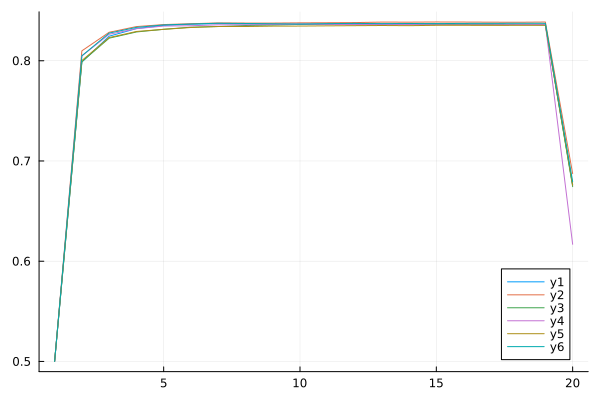

In [73]:
plot(auroc_pmlp_spks)

In [75]:
getindex.(argmax(auroc_pmlp_spks, dims=1), 1)

1×6 Matrix{Int64}:
 7  15  10  16  19  7

In [85]:
auroc_pmlp_final = auroc_pmlp_spks[16,:]

6-element Vector{Float64}:
 0.8362914521043814
 0.8386020253715953
 0.8361625654259222
 0.8365095692310599
 0.8353501089124767
 0.8372543354834014

In [81]:
auroc_pmlp_spk = x -> auroc_many(x, predict_pmlp_spk)

#104 (generic function with 1 method)

In [25]:
auroc_pmlp_spks = auroc_pmlp_spk.(pmlps)

6-element Vector{Float64}:
 0.8359925830806919
 0.8386279151406931
 0.8359770457887297
 0.8362087636787959
 0.835385572564386
 0.8373257645456256

In [86]:
auroc_pmlps .- auroc_pmlp_final

6-element Vector{Float64}:
  0.0021529667378717976
 -0.00010773390341023426
  0.0036795510348365257
  0.00022112772597737695
  0.0016789837998120172
  0.0011499178371279228

In [87]:
using StatsPlots

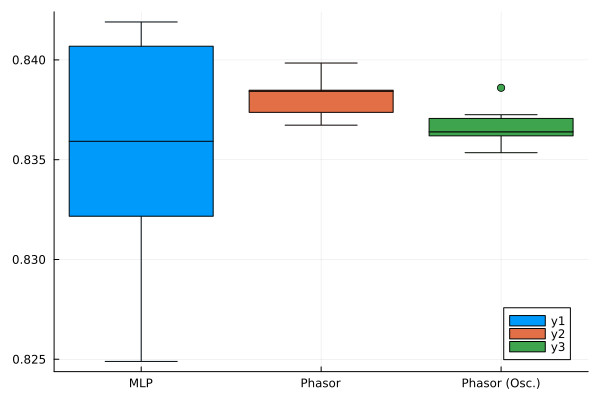

In [88]:
boxplot(stack((auroc_mlps, auroc_pmlps, auroc_pmlp_final), dims=2))
xticks!([1.0, 2.0, 3.0], ["MLP", "Phasor", "Phasor (Osc.)"])

In [89]:
using HypothesisTests

In [90]:
MannWhitneyUTest(auroc_pmlps, auroc_pmlp_final)

Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.00202383

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0931

Details:
    number of observations in each group: [6, 6]
    Mann-Whitney-U statistic:             29.0
    rank sums:                            [50.0, 28.0]
    adjustment for ties:                  0.0


In [26]:
function predict_ode(trained)
    params = trained["params"]
    state = trained["state"]

    global q
    global yl
    
    tspan = (0.0, 20.0)
    sa = SpikingArgs() #leakage = leakage, t_period = t_period)
    x = process_sample((q, yl), spk_args=sa, tspan=tspan)

    pred, _ = ode_model(x, params, state)
    return pred
end

predict_ode (generic function with 1 method)

In [27]:
auroc_ode = x -> auroc(x, predict_ode)

#74 (generic function with 1 method)

In [33]:
function predict_ode_spk(trained)
    params = trained["params"]
    state = trained["state"]

    global q
    global yl
    
    tspan = (0.0, 20.0)
    sa = SpikingArgs() #leakage = leakage, t_period = t_period)
    x = process_sample((q, yl), spk_args=sa, tspan=tspan)

    train, _ = ode_model_spk(x, params, state)
    preds = train_to_phase(train)
    return preds
end

predict_ode_spk (generic function with 1 method)

In [35]:
auroc_ode_spk = x -> auroc_many(x, predict_ode_spk)

#80 (generic function with 1 method)

In [29]:
odes = [load("trained_nns/ode_id_" * string(id) * "_epoch_10.jld2") for id in ids]

6-element Vector{Dict{String, Any}}:
 Dict("params" => (layer_1 = (weight = [0.7930513097940771 0.3074772343951109 … -0.1872961591967357 0.0757243291808084; 0.034898005096837575 0.7358750470338535 … 0.19122112588437243 -0.2834760205863029; … ; -0.13439883982587644 0.2192443051366847 … 1.0011471811339159 -0.2087711696966451; -0.327026018639483 -0.2985726718689862 … -0.19635014986439012 1.4021935787837878], leakage = [-0.2998471016025452], t_period = [1.013799067791795]), layer_2 = Float64[], layer_3 = (weight = [0.24852103538188533 0.08092182255225246 … -0.03923106017400753 -0.009880093968629983; 0.05803449002100956 -0.006172700495999418 … 0.08407726032827847 0.08515255085372328; … ; -0.09257822525604394 -0.10462639030474721 … 0.03779488107844676 -0.02117078388876043; -0.0986160648279876 -0.05606731022290075 … 0.1427990599237671 -0.21621816764202897], bias_real = [0.9252316233722399, 1.0032705352368765, 0.9360124671905611, 0.9244522264306212, 0.936276890058577, 1.029784702358902, 1.0514

In [32]:
auroc_ode(odes[1])

0.76355767951155

In [36]:
auroc_ode_spk(odes[1])

20×1×1 Array{Float64, 3}:
[:, :, 1] =
 0.5
 0.7116999526428965
 0.7257244443315543
 0.7403783574271452
 0.7134164871909426
 0.6790056980486491
 0.6664025336694185
 0.6642817872505762
 0.66328849200058
 0.6594590317242501
 0.6532880005648198
 0.6476352039821627
 0.6445225350206102
 0.6473060156103964
 0.6513495189206768
 0.6597629898025894
 0.6677942613259666
 0.680781678280192
 0.688027741475994
 0.6074458782279443

In [37]:
auroc_ode.(odes)

6-element Vector{Float64}:
 0.76355767951155
 0.7866428883469955
 0.6398504675582354
 0.8391880439705588
 0.8497347161315086
 0.7392319752277734

In [ ]:
auroc_ode(odes[1])

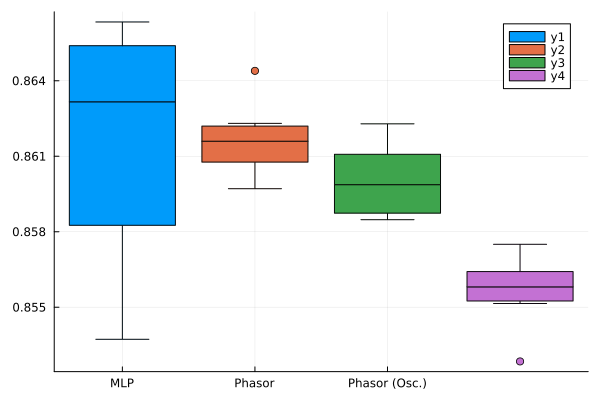

In [33]:
boxplot(stack((auroc_mlps, auroc_pmlps, auroc_pmlp_spks, auroc_odes), dims=2))
xticks!([1.0, 2.0, 3.0], ["MLP", "Phasor", "Phasor (Osc.)", "Phasor-ODE"])